In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     return x

## data folder set up and test

In [2]:
dataFolder = 'data/mainData/'
plt.ion()

In [3]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


In [ ]:
print(filename)
oneImageData = np.load(dataFolder+filename)

# print(oneImageData)
print(oneImageData.shape)


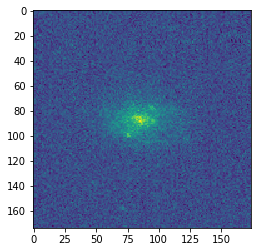

In [5]:
plt.imshow(oneImageData)

# Check a few random images 


1237662306200912201.npy
1237668297682518207.npy
1237665565008200031.npy
1237665428633747667.npy
1237665129070330015.npy


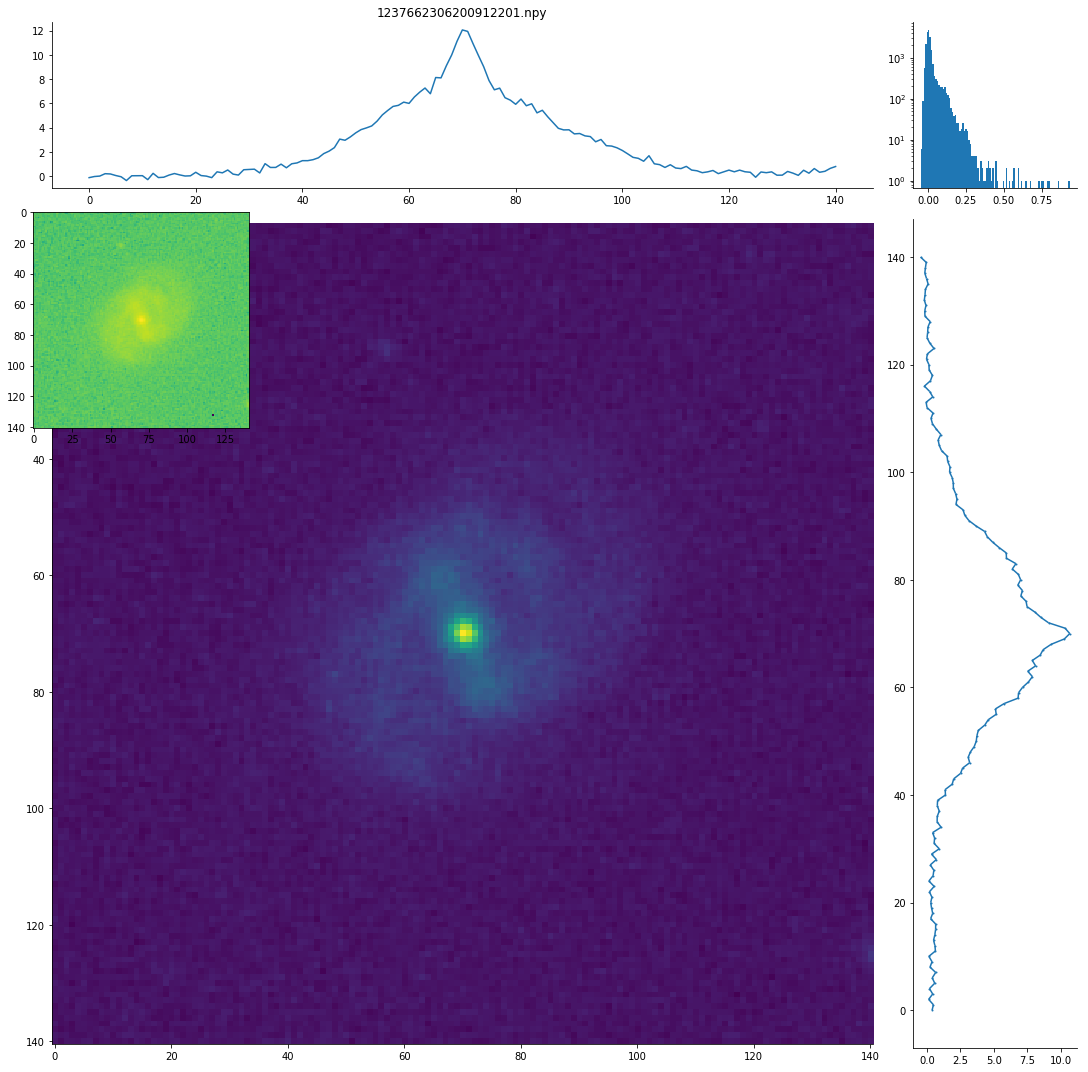

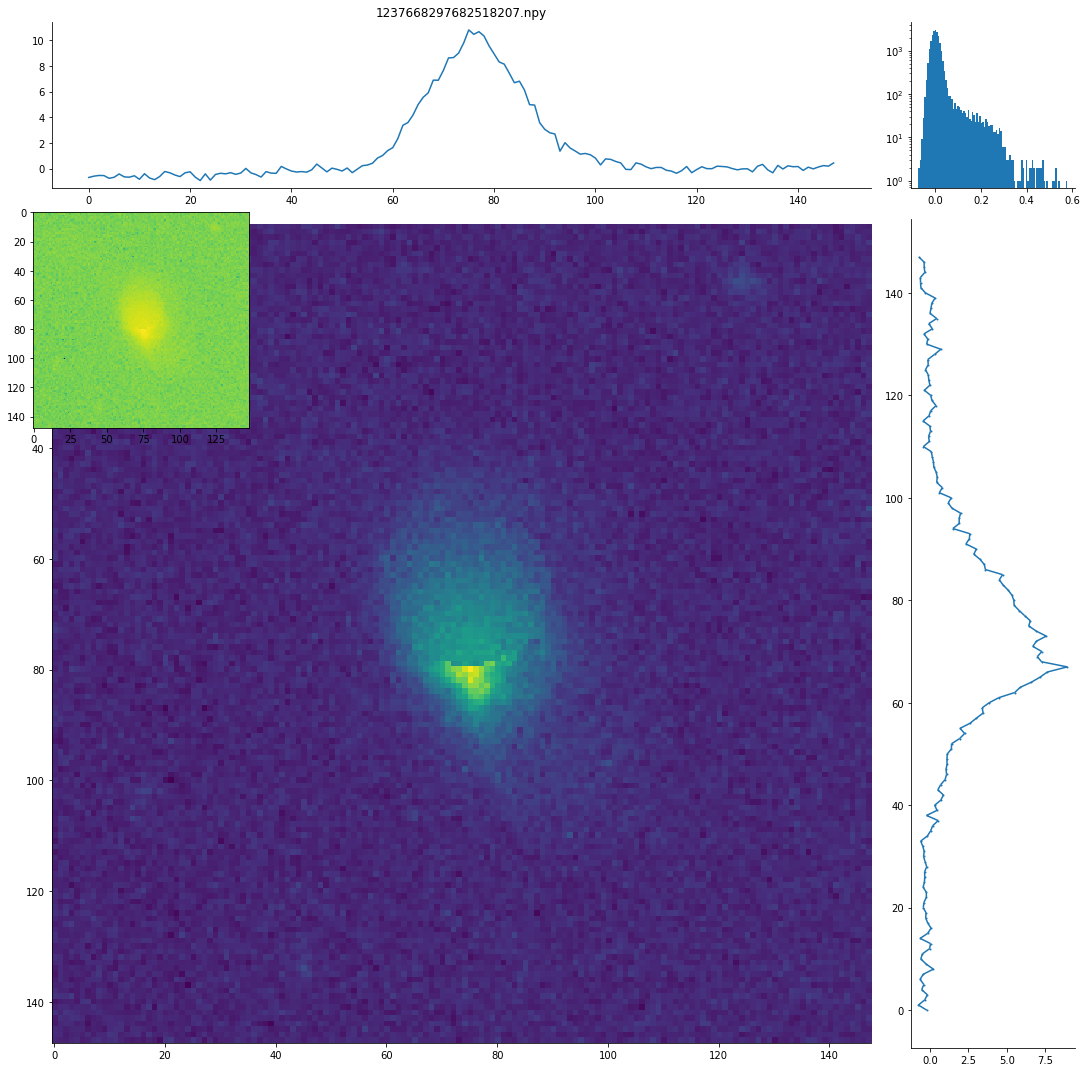

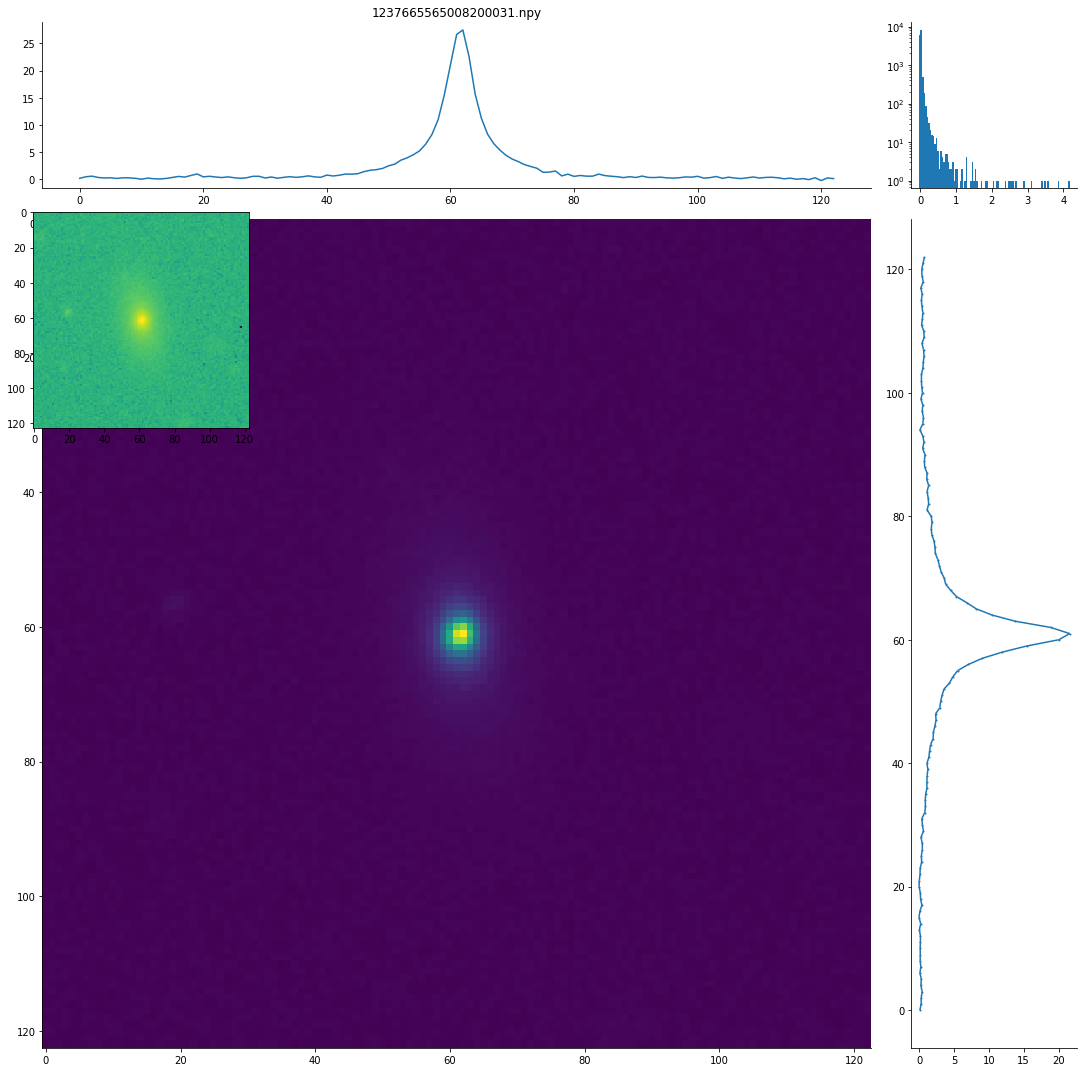

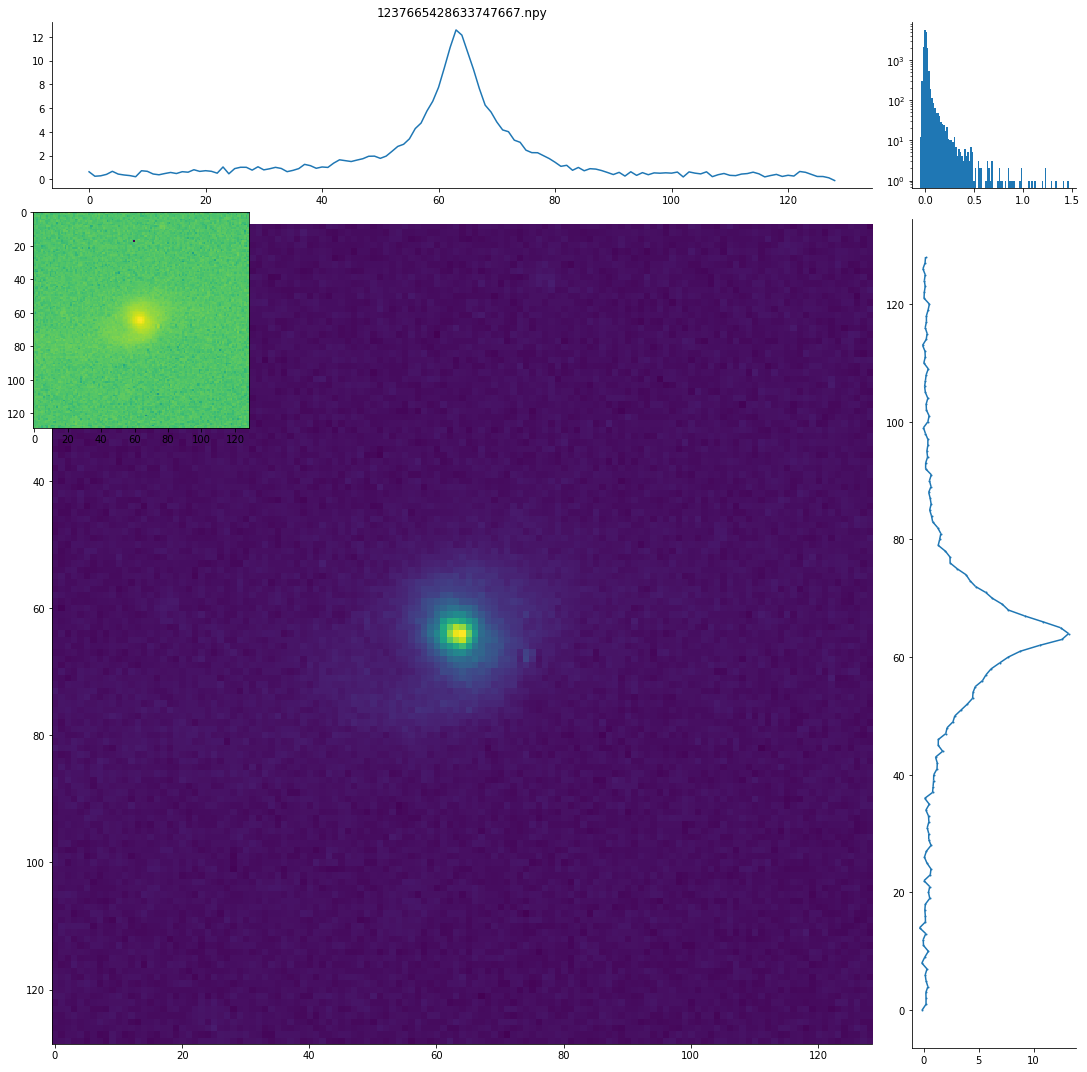

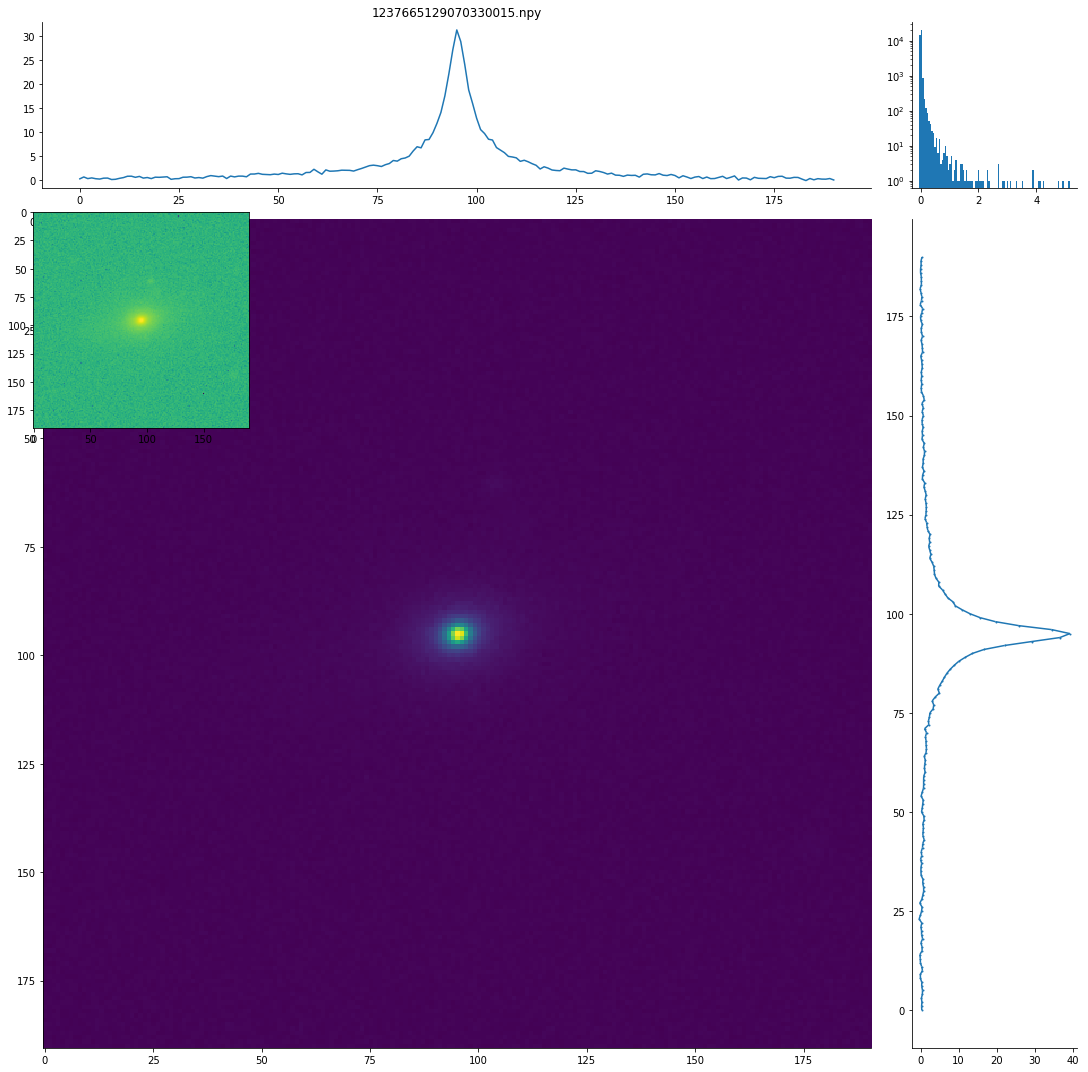

In [68]:
def drawOneGalaxy(fileName):
    oneImageData = np.load(dataFolder+fileName)
    print(fileName)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(fileName)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
    drawOneGalaxy(dataFileList[i])
    


In [ ]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [69]:
print('test')

test


# ML part

In [11]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [12]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

# drawOneGalaxy('1237662637444694216.npy')
def read_image(id):
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    else:
        X = np.load(dataFolder+id + '.npy')
    X = np.float32(X)
    return X

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def img_preproc(id):
    Xg = read_image(id)
    Xg = normalize_image(Xg)

#     h,w = Xg.shape
#     cy, cx = h//2, w//2
#     dy, dx = cy, cx # no shrinking
#     Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]

    Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)    
    return Xgr

x = img_preproc('1237662637444694216.npy')

### Load pretrained networks

In [13]:
vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [14]:
df =  pd.read_fwf('metaData.dat', comment = '#')
df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc
10,1237662635825954925,210.95489999999998,12.64455,0.33113110693986714,0.1029,-99.0,-99.0,42.47806067869379,440.99999325616017,0.8552113203991983
11,1237652947452297303,0.84015,-9.98328,0.5248074948227709,0.0767,11.312,0.016,50.181626715917524,328.7142940929958,0.6374607478101917
12,1237652899137912944,1.0026,-11.17802,0.6165950323262803,0.0383,9.708,0.071,29.440699795795908,164.1428577048438,0.3183148122868964
13,1237661433779716229,211.48905000000002,43.88251,0.7585775667003197,0.0337,9.26,0.062,31.869792393005813,144.4285735487938,0.28008379359836033
14,1237652944786555077,1.48395,16.13445,0.3388441338170015,0.0909,10.7,0.04,38.39840364463448,389.571413397789,0.7554782039377076


In [15]:
df['RA'] = df['RA'].apply(float)
df['DEC'] = df['DEC'].apply(float)
df['D25'] = df['D25'].apply(float)
df['redshi'] = df['redshi'].apply(float)
df['logMstar'] = df['logMst'].apply(float) #renamed
df['err_logMstar'] = df['err_l'].apply(float) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(float)
df['Distance'] = df['D_Mpc'].apply(float) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(float)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance
count,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000,187742.000000
mean,184.527190,24.898677,0.445798,0.074652,38.318105,0.620438,9.081941,-1.313631,319.936358
std,61.620064,19.374103,0.168006,0.040143,18.942158,0.333632,12.706553,11.469736,172.041273
min,0.008250,-11.252830,0.316228,0.010000,4.034125,0.083111,-99.000000,-99.000000,42.857142
25%,152.349938,8.662358,0.346737,0.044100,25.157782,0.366519,10.191000,0.021000,189.000006
50%,185.824575,23.197910,0.389045,0.069000,35.525868,0.573465,10.693000,0.029000,295.714278
75%,222.151537,39.835143,0.478630,0.096400,48.283920,0.801189,11.032000,0.041000,413.142858
max,359.994900,70.133250,10.964781,0.299600,1373.931687,2.490003,12.326000,0.800000,1284.000022


In [16]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+x+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

80306
107436


### Filter images that have no known mass, no actual image, or with an unknown error

In [17]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,RA,DEC,D25,redshi,GalSize_kpc,d_pix_kpc,logMstar,err_logMstar,Distance
count,78859.000000,78859.000000,78859.000000,78859.000000,78859.000000,78859.000000,78859.000000,78859.000000,78859.000000
mean,185.306782,25.673118,0.557664,0.058701,38.102726,0.487873,10.558259,0.031067,251.577396
std,57.110656,18.945305,0.194531,0.032567,19.838093,0.270665,0.654456,0.016955,139.571582
min,0.009450,-11.238420,0.407380,0.010000,5.248929,0.083111,7.376000,0.000000,42.857142
25%,154.488000,9.795145,0.436516,0.033800,24.390653,0.280915,10.200000,0.019000,144.857136
50%,186.753600,24.402030,0.489779,0.052300,35.044819,0.434670,10.692000,0.028000,224.142852
75%,221.981025,40.095235,0.602560,0.075600,47.501288,0.628319,11.031000,0.039000,323.999992
max,359.994900,70.133250,10.964781,0.294800,1373.931687,2.450110,12.326000,0.778000,1263.428628


In [18]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,logMstar,err_logMstar,Distance,hasFile,lin_mass,lin_err
184,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.14285392420635,0.632474,10.325,0.045,326.142854,True,2.113489e+10,2.189920e+09
226,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.5714168207986,0.569310,9.824,0.040,293.571417,True,6.668068e+09,6.141517e+08
247,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.1428605914116,0.324133,9.923,0.053,167.142861,True,8.375293e+09,1.022096e+09
286,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.0000158888953,0.546870,10.356,0.079,282.000016,True,2.269865e+10,4.128980e+09
342,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.9999960405486,0.378155,9.234,0.094,194.999996,True,1.713957e+09,3.709741e+08


In [19]:
print(len(df.SDSS_ID.values))

78851


# Iteration parameters defined here:

- N is the number of galaxies to use for this run
- M is the number of galaxies to train set (rest is holdout)
- chunkSize is the number of galaxies to evaluate at once
- prefixThisRound is the model name, for serialization purposes

In [20]:
N = len(df.SDSS_ID.values)
M = int(N*.8
prefixThisRound = 'sp.rawimg.model1'

chunkSize = 500
# N = 3000 # number of galaxies to take into consideration
# M = 2000 # train vs holdout


In [21]:
ids = df.SDSS_ID.values[:N]
Y = df.logMstar.values[:N]
err = df.err_logMstar.values[:N]
Y_lin = df.lin_mass.values[:N]
err_lin = df.lin_err.values[:N]

In [24]:
# debug function

import sys
def print_var_memory_usage():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
            for x in dir() 
               if not x.startswith('_') 
    #         and x not in sys.modules
            and x not in ipython_vars], key=lambda x: x[1], reverse=True)
    print(mm)
    

In [ ]:
print(N)
print(M)
print(chunkSize)
print(prefixThisRound)

In [28]:
crap instruction to make the auto execution stop here :p

SyntaxError: invalid syntax (<ipython-input-28-9b8943694fca>, line 1)

### call img_preproc on all images, per batches of "chunkSize" and save them to disk

In [36]:
def chunkFileName(chunkSize, prefix, chunkNumber):
    fileName = 'Xg3-'+str(chunkSize)+prefix+'-chunk-' + str(chunkNumber) + '.npy'
    return fileName

In [32]:
reloadImagesAndPreprocess = 0

maxChunkNumber = math.ceil(len(ids)/chunkSize)

fileName = chunkFileName(chunkSize, prefixThisRound, maxChunkNumber)
if ( reloadImagesAndPreprocess == 1 or not(os.path.isfile(fileName))):
    chunkStart = 0
    for chunkStart in tqdm(range(0, len(ids), chunkSize)):
        curChunk = int((chunkStart//chunkSize))
        valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart
        Xg_ = []
        
        for i in range(chunkStart, chunkStart+valuesInThisChunk):
            Xg_.append(img_preproc(ids[i]))

        Xg = np.stack(Xg_)

        Xg3 = np.zeros((valuesInThisChunk,224,224,3))

        Xg3[:,:,:,:] = Xg.reshape(valuesInThisChunk,224,224,1)

        fileName = chunkFileName(chunkSize, prefixThisRound, curChunk)
        np.save(fileName,Xg3)

print('done')

  0%|          | 0/158 [00:00<?, ?it/s]

loading


100%|██████████| 158/158 [02:41<00:00,  1.58it/s]

done


### Generate features based on the preprocessed images, pretrained networks and flux densities

In [38]:
Xg3r50 = []
Xg3vgg16 = []
extraImgFeatures = []
csize=2

chunkStart = 0
for chunkStart in tqdm(range(0, len(ids), chunkSize)):
    curChunk = int((chunkStart//chunkSize))
    valuesInThisChunk = min(chunkStart+chunkSize,len(ids))-chunkStart

    Xg3 = np.load(chunkFileName(chunkSize, prefixThisRound, curChunk))

    Xg3r50_ = r50.predict(Xg3).reshape(valuesInThisChunk, 2048)
    Xg3vgg16_ = vgg16.predict(Xg3)
    ex = np.hstack([
        np.sum(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.min(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.max(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.mean(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        np.std(Xg3.reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,1),
        Xg3[:,112,112,0].reshape(valuesInThisChunk,1),       # center
        np.mean(Xg3[:,112-csize:112+csize,112-csize:112+csize,0].reshape(valuesInThisChunk,-1),axis=1).reshape(valuesInThisChunk,-1) # mean center
        ])

    if chunkStart == 0:
        Xg3r50 = Xg3r50_
        Xg3vgg16 = Xg3vgg16_
        extraImgFeatures = ex
    else:
        Xg3r50 = np.concatenate([Xg3r50,Xg3r50_], axis=0)
        Xg3vgg16 = np.concatenate([Xg3vgg16,Xg3vgg16_], axis=0)
        extraImgFeatures = np.concatenate([extraImgFeatures,ex], axis=0)
        
        
extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']


100%|██████████| 158/158 [13:42<00:00,  5.40s/it]


In [39]:
Xg3 = None
Xg = None
X = None

In [44]:
Distance = df.Distance.values[:N].reshape(N,1)

Xg3f = np.hstack ( ( 
        Xg3r50, 
        Xg3vgg16, 
        Distance,
        1/Distance,
        Distance**2,
        1/(Distance**2),
        Distance**3,
        1/(Distance**3),
        np.log(Distance),
        1/np.log(Distance),
        np.log(Distance**2),
        1/np.log(Distance**2),
        np.log(Distance)**2,
        1/np.log(Distance)**2,
        extraImgFeatures
        ) )

distanceNames = ['D', '1/D', 'D**2', '1/D**2', 'D**3', '1/D**3', 'log(D)', '1/log(D)', 'log(D**2)', 'log(1/D**2)', 'log(D)**2', '1/log(D)**2' ]

In [45]:
extraImgFeatureNames = ['norm.flux.sum', 'norm.flux.min', 'norm.flux.max', 'norm.flux.mean', 'norm.flux.std', 'center.flux', 'aroundCenter.flux']

Xg3fNames = ( [prefixThisRound+'.r50.' + str(i) for i in range(Xg3r50.shape[1])]
            + [prefixThisRound+'.vgg16.' + str(i) for i in range(Xg3vgg16.shape[1])] 
            + [prefixThisRound+'.'+ n for n in distanceNames]
            + [prefixThisRound+'.'+ n for n in extraImgFeatureNames])

print(len(Xg3fNames), Xg3f.shape)

3067 (78851, 3067)


### Generate the train/test datasets for lgbm regression

In [46]:
dtrain = lgbm.Dataset(Xg3f[:M], label= Y[:M])
dtest = lgbm.Dataset(Xg3f[M:], label= Y[M:])


In [47]:

lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'nthread': 4,
    #'silent': True,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_bin': 255,
    #'subsample_for_bin': 50000,
    #'subsample': 0.8,
    #'subsample_freq': 1,
    #'colsample_bytree': 0.8,
    #'reg_alpha': 1,
    #'reg_lambda': 0,
    #'min_split_gain': 0.5,
    #'min_child_weight': 1,
    #'min_child_samples': 60,
    #'scale_pos_weight': 1,
    'device' : 'gpu',
    'metric' : 'rmse',
    #'metric' : 'multi_error',
    'verbose':0,          
}

In [48]:
bst=lgbm.cv(lgbm_params, dtrain, num_boost_round=10000, nfold=3, stratified=False, shuffle=True,
              metrics=None, fobj=None, feval=None, init_model=None, feature_name='auto',
              categorical_feature='auto', early_stopping_rounds=100, fpreproc=None,
              verbose_eval=5, show_stdv=True, seed=0, callbacks=None)



[5]	cv_agg's rmse: 0.628652 + 0.00218605
[10]	cv_agg's rmse: 0.606653 + 0.00206943
[15]	cv_agg's rmse: 0.585883 + 0.00196233
[20]	cv_agg's rmse: 0.56622 + 0.00182173
[25]	cv_agg's rmse: 0.547581 + 0.00169732
[30]	cv_agg's rmse: 0.53001 + 0.001565
[35]	cv_agg's rmse: 0.513335 + 0.00147742
[40]	cv_agg's rmse: 0.497618 + 0.00137884
[45]	cv_agg's rmse: 0.482721 + 0.00130724
[50]	cv_agg's rmse: 0.468729 + 0.00121683
[55]	cv_agg's rmse: 0.455477 + 0.00112981
[60]	cv_agg's rmse: 0.443138 + 0.00104463
[65]	cv_agg's rmse: 0.431452 + 0.00102098
[70]	cv_agg's rmse: 0.420484 + 0.000902534
[75]	cv_agg's rmse: 0.410156 + 0.000799394
[80]	cv_agg's rmse: 0.400409 + 0.000662734
[85]	cv_agg's rmse: 0.391216 + 0.000532184
[90]	cv_agg's rmse: 0.382558 + 0.000395171
[95]	cv_agg's rmse: 0.374444 + 0.000268941
[100]	cv_agg's rmse: 0.36678 + 0.000213752
[105]	cv_agg's rmse: 0.35963 + 0.000158214
[110]	cv_agg's rmse: 0.352886 + 0.000193307
[115]	cv_agg's rmse: 0.346588 + 0.000254364
[120]	cv_agg's rmse: 0.3406

[965]	cv_agg's rmse: 0.221272 + 0.00154168
[970]	cv_agg's rmse: 0.221188 + 0.00153859
[975]	cv_agg's rmse: 0.221109 + 0.00153995
[980]	cv_agg's rmse: 0.221034 + 0.0015367
[985]	cv_agg's rmse: 0.22095 + 0.00153372
[990]	cv_agg's rmse: 0.220874 + 0.00153493
[995]	cv_agg's rmse: 0.220794 + 0.00153473
[1000]	cv_agg's rmse: 0.220725 + 0.00153994
[1005]	cv_agg's rmse: 0.220648 + 0.00154737
[1010]	cv_agg's rmse: 0.220577 + 0.00154741
[1015]	cv_agg's rmse: 0.220502 + 0.00153147
[1020]	cv_agg's rmse: 0.220428 + 0.00153525
[1025]	cv_agg's rmse: 0.220353 + 0.00153805
[1030]	cv_agg's rmse: 0.220289 + 0.0015392
[1035]	cv_agg's rmse: 0.220221 + 0.00153957
[1040]	cv_agg's rmse: 0.220155 + 0.00153669
[1045]	cv_agg's rmse: 0.220092 + 0.00154313
[1050]	cv_agg's rmse: 0.220017 + 0.00153969
[1055]	cv_agg's rmse: 0.219949 + 0.00154152
[1060]	cv_agg's rmse: 0.219883 + 0.00153314
[1065]	cv_agg's rmse: 0.219815 + 0.00153482
[1070]	cv_agg's rmse: 0.219748 + 0.00153128
[1075]	cv_agg's rmse: 0.219684 + 0.0015351

[1905]	cv_agg's rmse: 0.214038 + 0.00156716
[1910]	cv_agg's rmse: 0.214021 + 0.00156569
[1915]	cv_agg's rmse: 0.213998 + 0.00156782
[1920]	cv_agg's rmse: 0.21398 + 0.00156977
[1925]	cv_agg's rmse: 0.213964 + 0.00156967
[1930]	cv_agg's rmse: 0.213948 + 0.00157059
[1935]	cv_agg's rmse: 0.213928 + 0.00157542
[1940]	cv_agg's rmse: 0.213916 + 0.00158016
[1945]	cv_agg's rmse: 0.213898 + 0.00158169
[1950]	cv_agg's rmse: 0.213882 + 0.00158227
[1955]	cv_agg's rmse: 0.213868 + 0.00158481
[1960]	cv_agg's rmse: 0.213854 + 0.00158075
[1965]	cv_agg's rmse: 0.213837 + 0.00158015
[1970]	cv_agg's rmse: 0.21382 + 0.0015885
[1975]	cv_agg's rmse: 0.213806 + 0.0015889
[1980]	cv_agg's rmse: 0.213793 + 0.00158932
[1985]	cv_agg's rmse: 0.213777 + 0.00158972
[1990]	cv_agg's rmse: 0.213767 + 0.00158772
[1995]	cv_agg's rmse: 0.213747 + 0.00158616
[2000]	cv_agg's rmse: 0.213732 + 0.00159129
[2005]	cv_agg's rmse: 0.21372 + 0.00159094
[2010]	cv_agg's rmse: 0.213709 + 0.00159184
[2015]	cv_agg's rmse: 0.213694 + 0.00

[2845]	cv_agg's rmse: 0.211802 + 0.00165067
[2850]	cv_agg's rmse: 0.211796 + 0.00165084
[2855]	cv_agg's rmse: 0.211783 + 0.00165246
[2860]	cv_agg's rmse: 0.211772 + 0.00165296
[2865]	cv_agg's rmse: 0.211765 + 0.00165263
[2870]	cv_agg's rmse: 0.211755 + 0.00165608
[2875]	cv_agg's rmse: 0.211745 + 0.00165499
[2880]	cv_agg's rmse: 0.211734 + 0.00165477
[2885]	cv_agg's rmse: 0.211725 + 0.00165502
[2890]	cv_agg's rmse: 0.21172 + 0.00165844
[2895]	cv_agg's rmse: 0.211716 + 0.00165911
[2900]	cv_agg's rmse: 0.211707 + 0.0016612
[2905]	cv_agg's rmse: 0.2117 + 0.0016634
[2910]	cv_agg's rmse: 0.211692 + 0.00166341
[2915]	cv_agg's rmse: 0.211685 + 0.00166284
[2920]	cv_agg's rmse: 0.21168 + 0.0016629
[2925]	cv_agg's rmse: 0.211669 + 0.00166502
[2930]	cv_agg's rmse: 0.211661 + 0.00166948
[2935]	cv_agg's rmse: 0.211651 + 0.00166539
[2940]	cv_agg's rmse: 0.211642 + 0.00166783
[2945]	cv_agg's rmse: 0.211637 + 0.00166986
[2950]	cv_agg's rmse: 0.211624 + 0.00167358
[2955]	cv_agg's rmse: 0.211618 + 0.0016

[3785]	cv_agg's rmse: 0.210607 + 0.00171177
[3790]	cv_agg's rmse: 0.210601 + 0.00171266
[3795]	cv_agg's rmse: 0.210591 + 0.00171193
[3800]	cv_agg's rmse: 0.210587 + 0.00171106
[3805]	cv_agg's rmse: 0.210581 + 0.00171161
[3810]	cv_agg's rmse: 0.210577 + 0.00170909
[3815]	cv_agg's rmse: 0.210571 + 0.00171023
[3820]	cv_agg's rmse: 0.210567 + 0.0017095
[3825]	cv_agg's rmse: 0.210564 + 0.0017073
[3830]	cv_agg's rmse: 0.210555 + 0.00171009
[3835]	cv_agg's rmse: 0.210548 + 0.00170898
[3840]	cv_agg's rmse: 0.210544 + 0.0017097
[3845]	cv_agg's rmse: 0.21054 + 0.00170838
[3850]	cv_agg's rmse: 0.210536 + 0.00170832
[3855]	cv_agg's rmse: 0.210535 + 0.00170989
[3860]	cv_agg's rmse: 0.210528 + 0.00170718
[3865]	cv_agg's rmse: 0.210524 + 0.00170887
[3870]	cv_agg's rmse: 0.210519 + 0.00170991
[3875]	cv_agg's rmse: 0.210513 + 0.00170995
[3880]	cv_agg's rmse: 0.210508 + 0.00171022
[3885]	cv_agg's rmse: 0.2105 + 0.00171117
[3890]	cv_agg's rmse: 0.210493 + 0.00171143
[3895]	cv_agg's rmse: 0.210489 + 0.001

[4725]	cv_agg's rmse: 0.209784 + 0.0016552
[4730]	cv_agg's rmse: 0.209781 + 0.00165454
[4735]	cv_agg's rmse: 0.20978 + 0.00165416
[4740]	cv_agg's rmse: 0.209774 + 0.00165365
[4745]	cv_agg's rmse: 0.20977 + 0.00165601
[4750]	cv_agg's rmse: 0.209765 + 0.00165629
[4755]	cv_agg's rmse: 0.20976 + 0.00165279
[4760]	cv_agg's rmse: 0.209756 + 0.00165271
[4765]	cv_agg's rmse: 0.209752 + 0.00165105
[4770]	cv_agg's rmse: 0.209748 + 0.00165189
[4775]	cv_agg's rmse: 0.209747 + 0.00164938
[4780]	cv_agg's rmse: 0.209743 + 0.00164987
[4785]	cv_agg's rmse: 0.209739 + 0.00165017
[4790]	cv_agg's rmse: 0.209734 + 0.00164901
[4795]	cv_agg's rmse: 0.209728 + 0.00164898
[4800]	cv_agg's rmse: 0.209724 + 0.0016479
[4805]	cv_agg's rmse: 0.209724 + 0.00164836
[4810]	cv_agg's rmse: 0.209721 + 0.00165265
[4815]	cv_agg's rmse: 0.209719 + 0.00165161
[4820]	cv_agg's rmse: 0.209713 + 0.00165306
[4825]	cv_agg's rmse: 0.209709 + 0.00165178
[4830]	cv_agg's rmse: 0.209704 + 0.00165045
[4835]	cv_agg's rmse: 0.209699 + 0.00

[5660]	cv_agg's rmse: 0.209134 + 0.0016558
[5665]	cv_agg's rmse: 0.20913 + 0.00165445
[5670]	cv_agg's rmse: 0.209129 + 0.00165515
[5675]	cv_agg's rmse: 0.209127 + 0.00165797
[5680]	cv_agg's rmse: 0.209122 + 0.00166001
[5685]	cv_agg's rmse: 0.209119 + 0.0016618
[5690]	cv_agg's rmse: 0.209115 + 0.00166122
[5695]	cv_agg's rmse: 0.209111 + 0.0016616
[5700]	cv_agg's rmse: 0.209108 + 0.00166118
[5705]	cv_agg's rmse: 0.209104 + 0.00166143
[5710]	cv_agg's rmse: 0.209099 + 0.00165981
[5715]	cv_agg's rmse: 0.209099 + 0.0016605
[5720]	cv_agg's rmse: 0.209096 + 0.00166244
[5725]	cv_agg's rmse: 0.209093 + 0.00166205
[5730]	cv_agg's rmse: 0.209088 + 0.00166198
[5735]	cv_agg's rmse: 0.209084 + 0.00166204
[5740]	cv_agg's rmse: 0.209082 + 0.00166259
[5745]	cv_agg's rmse: 0.209078 + 0.00166195
[5750]	cv_agg's rmse: 0.209075 + 0.00166307
[5755]	cv_agg's rmse: 0.209071 + 0.00166072
[5760]	cv_agg's rmse: 0.209068 + 0.00165983
[5765]	cv_agg's rmse: 0.209067 + 0.00166173
[5770]	cv_agg's rmse: 0.209066 + 0.00

[6600]	cv_agg's rmse: 0.20861 + 0.00170538
[6605]	cv_agg's rmse: 0.208607 + 0.00170498
[6610]	cv_agg's rmse: 0.208605 + 0.00170561
[6615]	cv_agg's rmse: 0.208601 + 0.00170584
[6620]	cv_agg's rmse: 0.208598 + 0.00170661
[6625]	cv_agg's rmse: 0.208593 + 0.00170656
[6630]	cv_agg's rmse: 0.208591 + 0.00170562
[6635]	cv_agg's rmse: 0.208589 + 0.00170712
[6640]	cv_agg's rmse: 0.208588 + 0.00170666
[6645]	cv_agg's rmse: 0.208585 + 0.00170655
[6650]	cv_agg's rmse: 0.208583 + 0.00170605
[6655]	cv_agg's rmse: 0.20858 + 0.00170488
[6660]	cv_agg's rmse: 0.208575 + 0.00170363
[6665]	cv_agg's rmse: 0.208573 + 0.00170554
[6670]	cv_agg's rmse: 0.208573 + 0.00170453
[6675]	cv_agg's rmse: 0.20857 + 0.00170467
[6680]	cv_agg's rmse: 0.208566 + 0.0017057
[6685]	cv_agg's rmse: 0.208564 + 0.00170626
[6690]	cv_agg's rmse: 0.208561 + 0.0017059
[6695]	cv_agg's rmse: 0.20856 + 0.00170798
[6700]	cv_agg's rmse: 0.208558 + 0.00170842
[6705]	cv_agg's rmse: 0.208557 + 0.00170827
[6710]	cv_agg's rmse: 0.208554 + 0.001

[7540]	cv_agg's rmse: 0.208188 + 0.00174168
[7545]	cv_agg's rmse: 0.208184 + 0.00174086
[7550]	cv_agg's rmse: 0.208183 + 0.0017422
[7555]	cv_agg's rmse: 0.208183 + 0.00174079
[7560]	cv_agg's rmse: 0.20818 + 0.00174064
[7565]	cv_agg's rmse: 0.208178 + 0.00173893
[7570]	cv_agg's rmse: 0.208176 + 0.00174065
[7575]	cv_agg's rmse: 0.208175 + 0.00173904
[7580]	cv_agg's rmse: 0.208173 + 0.00173867
[7585]	cv_agg's rmse: 0.208172 + 0.00173838
[7590]	cv_agg's rmse: 0.208171 + 0.00173805
[7595]	cv_agg's rmse: 0.208169 + 0.00173904
[7600]	cv_agg's rmse: 0.208165 + 0.00173825
[7605]	cv_agg's rmse: 0.208164 + 0.00173828
[7610]	cv_agg's rmse: 0.208163 + 0.00173822
[7615]	cv_agg's rmse: 0.208161 + 0.00174061
[7620]	cv_agg's rmse: 0.208159 + 0.00173905
[7625]	cv_agg's rmse: 0.208156 + 0.00173775
[7630]	cv_agg's rmse: 0.208153 + 0.00173725
[7635]	cv_agg's rmse: 0.208149 + 0.0017372
[7640]	cv_agg's rmse: 0.208147 + 0.0017385
[7645]	cv_agg's rmse: 0.208145 + 0.00174008
[7650]	cv_agg's rmse: 0.208143 + 0.0

[8475]	cv_agg's rmse: 0.207886 + 0.00175507
[8480]	cv_agg's rmse: 0.207884 + 0.00175504
[8485]	cv_agg's rmse: 0.20788 + 0.00175711
[8490]	cv_agg's rmse: 0.20788 + 0.0017578
[8495]	cv_agg's rmse: 0.207878 + 0.00175861
[8500]	cv_agg's rmse: 0.207876 + 0.00175991
[8505]	cv_agg's rmse: 0.207876 + 0.00175969
[8510]	cv_agg's rmse: 0.207875 + 0.00175977
[8515]	cv_agg's rmse: 0.207873 + 0.00176014
[8520]	cv_agg's rmse: 0.20787 + 0.00176058
[8525]	cv_agg's rmse: 0.20787 + 0.00175974
[8530]	cv_agg's rmse: 0.20787 + 0.00175958
[8535]	cv_agg's rmse: 0.207868 + 0.00175984
[8540]	cv_agg's rmse: 0.207868 + 0.00175983
[8545]	cv_agg's rmse: 0.207866 + 0.00176026
[8550]	cv_agg's rmse: 0.207864 + 0.00176016
[8555]	cv_agg's rmse: 0.207863 + 0.00175822
[8560]	cv_agg's rmse: 0.207863 + 0.00175765
[8565]	cv_agg's rmse: 0.207861 + 0.00175743
[8570]	cv_agg's rmse: 0.20786 + 0.00175625
[8575]	cv_agg's rmse: 0.207857 + 0.00175596
[8580]	cv_agg's rmse: 0.207856 + 0.00175531
[8585]	cv_agg's rmse: 0.207855 + 0.0017

[9415]	cv_agg's rmse: 0.207628 + 0.00175446
[9420]	cv_agg's rmse: 0.207626 + 0.00175333
[9425]	cv_agg's rmse: 0.207625 + 0.00175329
[9430]	cv_agg's rmse: 0.207625 + 0.00175377
[9435]	cv_agg's rmse: 0.207625 + 0.00175411
[9440]	cv_agg's rmse: 0.207623 + 0.00175465
[9445]	cv_agg's rmse: 0.207621 + 0.00175497
[9450]	cv_agg's rmse: 0.207619 + 0.00175514
[9455]	cv_agg's rmse: 0.207619 + 0.0017562
[9460]	cv_agg's rmse: 0.207619 + 0.00175623
[9465]	cv_agg's rmse: 0.207618 + 0.00175565
[9470]	cv_agg's rmse: 0.207616 + 0.00175431
[9475]	cv_agg's rmse: 0.207614 + 0.00175408
[9480]	cv_agg's rmse: 0.207612 + 0.00175387
[9485]	cv_agg's rmse: 0.207612 + 0.00175419
[9490]	cv_agg's rmse: 0.207611 + 0.00175402
[9495]	cv_agg's rmse: 0.20761 + 0.00175256
[9500]	cv_agg's rmse: 0.207609 + 0.0017528
[9505]	cv_agg's rmse: 0.207608 + 0.00175141
[9510]	cv_agg's rmse: 0.207605 + 0.00175226
[9515]	cv_agg's rmse: 0.207604 + 0.00175236
[9520]	cv_agg's rmse: 0.207603 + 0.00175371
[9525]	cv_agg's rmse: 0.207603 + 0.

In [49]:
num_boost_round = len(bst['rmse-mean'])-1
print(num_boost_round)


9999


In [50]:
model = lgbm.train(lgbm_params, dtrain, num_boost_round,
                   valid_sets=[dtest], valid_names=['test'], fobj=None, feval=None, 
                   init_model=None, feature_name='auto', categorical_feature='auto', 
                   early_stopping_rounds=100, evals_result=None, verbose_eval=5, 
                   learning_rates=None, callbacks=None)


Training until validation scores don't improve for 100 rounds.
[5]	test's rmse: 0.647244
[10]	test's rmse: 0.624545
[15]	test's rmse: 0.602944
[20]	test's rmse: 0.582419
[25]	test's rmse: 0.563396
[30]	test's rmse: 0.545326
[35]	test's rmse: 0.528243
[40]	test's rmse: 0.511918
[45]	test's rmse: 0.496321
[50]	test's rmse: 0.481786
[55]	test's rmse: 0.467762
[60]	test's rmse: 0.454637
[65]	test's rmse: 0.44237
[70]	test's rmse: 0.430733
[75]	test's rmse: 0.420033
[80]	test's rmse: 0.409999
[85]	test's rmse: 0.400546
[90]	test's rmse: 0.391205
[95]	test's rmse: 0.382927
[100]	test's rmse: 0.375019
[105]	test's rmse: 0.367363
[110]	test's rmse: 0.360154
[115]	test's rmse: 0.353592
[120]	test's rmse: 0.346972
[125]	test's rmse: 0.340951
[130]	test's rmse: 0.335197
[135]	test's rmse: 0.329787
[140]	test's rmse: 0.324666
[145]	test's rmse: 0.319982
[150]	test's rmse: 0.315332
[155]	test's rmse: 0.311091
[160]	test's rmse: 0.306963
[165]	test's rmse: 0.303377
[170]	test's rmse: 0.300092
[175]	

[1450]	test's rmse: 0.21297
[1455]	test's rmse: 0.212924
[1460]	test's rmse: 0.21288
[1465]	test's rmse: 0.212831
[1470]	test's rmse: 0.212787
[1475]	test's rmse: 0.212756
[1480]	test's rmse: 0.212729
[1485]	test's rmse: 0.212693
[1490]	test's rmse: 0.212674
[1495]	test's rmse: 0.212629
[1500]	test's rmse: 0.212582
[1505]	test's rmse: 0.212548
[1510]	test's rmse: 0.212494
[1515]	test's rmse: 0.212447
[1520]	test's rmse: 0.212426
[1525]	test's rmse: 0.212395
[1530]	test's rmse: 0.212349
[1535]	test's rmse: 0.212309
[1540]	test's rmse: 0.212295
[1545]	test's rmse: 0.212273
[1550]	test's rmse: 0.212235
[1555]	test's rmse: 0.212206
[1560]	test's rmse: 0.212169
[1565]	test's rmse: 0.212153
[1570]	test's rmse: 0.212124
[1575]	test's rmse: 0.212087
[1580]	test's rmse: 0.212066
[1585]	test's rmse: 0.212032
[1590]	test's rmse: 0.212003
[1595]	test's rmse: 0.211961
[1600]	test's rmse: 0.211931
[1605]	test's rmse: 0.211916
[1610]	test's rmse: 0.211891
[1615]	test's rmse: 0.211853
[1620]	test's rm

[2870]	test's rmse: 0.20805
[2875]	test's rmse: 0.208047
[2880]	test's rmse: 0.20804
[2885]	test's rmse: 0.208024
[2890]	test's rmse: 0.208007
[2895]	test's rmse: 0.207991
[2900]	test's rmse: 0.207984
[2905]	test's rmse: 0.207977
[2910]	test's rmse: 0.207969
[2915]	test's rmse: 0.207947
[2920]	test's rmse: 0.207943
[2925]	test's rmse: 0.207929
[2930]	test's rmse: 0.20792
[2935]	test's rmse: 0.207913
[2940]	test's rmse: 0.207906
[2945]	test's rmse: 0.207891
[2950]	test's rmse: 0.207879
[2955]	test's rmse: 0.207867
[2960]	test's rmse: 0.207863
[2965]	test's rmse: 0.207852
[2970]	test's rmse: 0.207852
[2975]	test's rmse: 0.207833
[2980]	test's rmse: 0.207823
[2985]	test's rmse: 0.20782
[2990]	test's rmse: 0.207814
[2995]	test's rmse: 0.207802
[3000]	test's rmse: 0.207792
[3005]	test's rmse: 0.207783
[3010]	test's rmse: 0.207772
[3015]	test's rmse: 0.207757
[3020]	test's rmse: 0.207751
[3025]	test's rmse: 0.207741
[3030]	test's rmse: 0.20773
[3035]	test's rmse: 0.207715
[3040]	test's rmse:

[4290]	test's rmse: 0.206343
[4295]	test's rmse: 0.20634
[4300]	test's rmse: 0.206338
[4305]	test's rmse: 0.206333
[4310]	test's rmse: 0.206334
[4315]	test's rmse: 0.206332
[4320]	test's rmse: 0.206326
[4325]	test's rmse: 0.20633
[4330]	test's rmse: 0.206322
[4335]	test's rmse: 0.206318
[4340]	test's rmse: 0.206311
[4345]	test's rmse: 0.206301
[4350]	test's rmse: 0.206293
[4355]	test's rmse: 0.206301
[4360]	test's rmse: 0.206293
[4365]	test's rmse: 0.206291
[4370]	test's rmse: 0.20629
[4375]	test's rmse: 0.206281
[4380]	test's rmse: 0.206278
[4385]	test's rmse: 0.206274
[4390]	test's rmse: 0.206264
[4395]	test's rmse: 0.206265
[4400]	test's rmse: 0.206264
[4405]	test's rmse: 0.206253
[4410]	test's rmse: 0.206248
[4415]	test's rmse: 0.206248
[4420]	test's rmse: 0.20624
[4425]	test's rmse: 0.206238
[4430]	test's rmse: 0.206235
[4435]	test's rmse: 0.206229
[4440]	test's rmse: 0.20622
[4445]	test's rmse: 0.206216
[4450]	test's rmse: 0.206215
[4455]	test's rmse: 0.206211
[4460]	test's rmse:

[5710]	test's rmse: 0.205395
[5715]	test's rmse: 0.205389
[5720]	test's rmse: 0.20539
[5725]	test's rmse: 0.205389
[5730]	test's rmse: 0.205383
[5735]	test's rmse: 0.205379
[5740]	test's rmse: 0.205376
[5745]	test's rmse: 0.205378
[5750]	test's rmse: 0.205381
[5755]	test's rmse: 0.20538
[5760]	test's rmse: 0.205371
[5765]	test's rmse: 0.205369
[5770]	test's rmse: 0.205363
[5775]	test's rmse: 0.20536
[5780]	test's rmse: 0.20536
[5785]	test's rmse: 0.205353
[5790]	test's rmse: 0.205349
[5795]	test's rmse: 0.205348
[5800]	test's rmse: 0.205345
[5805]	test's rmse: 0.205339
[5810]	test's rmse: 0.205335
[5815]	test's rmse: 0.205331
[5820]	test's rmse: 0.205329
[5825]	test's rmse: 0.205318
[5830]	test's rmse: 0.20532
[5835]	test's rmse: 0.205315
[5840]	test's rmse: 0.205315
[5845]	test's rmse: 0.205304
[5850]	test's rmse: 0.205299
[5855]	test's rmse: 0.2053
[5860]	test's rmse: 0.205298
[5865]	test's rmse: 0.205292
[5870]	test's rmse: 0.205292
[5875]	test's rmse: 0.205293
[5880]	test's rmse: 0

[7130]	test's rmse: 0.204763
[7135]	test's rmse: 0.204764
[7140]	test's rmse: 0.204765
[7145]	test's rmse: 0.204759
[7150]	test's rmse: 0.204754
[7155]	test's rmse: 0.204755
[7160]	test's rmse: 0.204751
[7165]	test's rmse: 0.204745
[7170]	test's rmse: 0.204745
[7175]	test's rmse: 0.204743
[7180]	test's rmse: 0.20474
[7185]	test's rmse: 0.204739
[7190]	test's rmse: 0.204738
[7195]	test's rmse: 0.204733
[7200]	test's rmse: 0.204725
[7205]	test's rmse: 0.204726
[7210]	test's rmse: 0.204723
[7215]	test's rmse: 0.20472
[7220]	test's rmse: 0.204716
[7225]	test's rmse: 0.204721
[7230]	test's rmse: 0.204719
[7235]	test's rmse: 0.204715
[7240]	test's rmse: 0.204718
[7245]	test's rmse: 0.204717
[7250]	test's rmse: 0.204717
[7255]	test's rmse: 0.204718
[7260]	test's rmse: 0.204719
[7265]	test's rmse: 0.204712
[7270]	test's rmse: 0.20471
[7275]	test's rmse: 0.204708
[7280]	test's rmse: 0.204708
[7285]	test's rmse: 0.204709
[7290]	test's rmse: 0.204707
[7295]	test's rmse: 0.204705
[7300]	test's rms

[8550]	test's rmse: 0.204307
[8555]	test's rmse: 0.204308
[8560]	test's rmse: 0.204306
[8565]	test's rmse: 0.2043
[8570]	test's rmse: 0.204299
[8575]	test's rmse: 0.204296
[8580]	test's rmse: 0.204291
[8585]	test's rmse: 0.20429
[8590]	test's rmse: 0.20429
[8595]	test's rmse: 0.20429
[8600]	test's rmse: 0.20429
[8605]	test's rmse: 0.204287
[8610]	test's rmse: 0.204284
[8615]	test's rmse: 0.20428
[8620]	test's rmse: 0.204276
[8625]	test's rmse: 0.204277
[8630]	test's rmse: 0.204279
[8635]	test's rmse: 0.204277
[8640]	test's rmse: 0.204281
[8645]	test's rmse: 0.204278
[8650]	test's rmse: 0.204274
[8655]	test's rmse: 0.204272
[8660]	test's rmse: 0.20427
[8665]	test's rmse: 0.204269
[8670]	test's rmse: 0.204269
[8675]	test's rmse: 0.204266
[8680]	test's rmse: 0.204265
[8685]	test's rmse: 0.204261
[8690]	test's rmse: 0.204261
[8695]	test's rmse: 0.204258
[8700]	test's rmse: 0.204255
[8705]	test's rmse: 0.20425
[8710]	test's rmse: 0.20425
[8715]	test's rmse: 0.204245
[8720]	test's rmse: 0.20

[9970]	test's rmse: 0.203947
[9975]	test's rmse: 0.203948
[9980]	test's rmse: 0.203948
[9985]	test's rmse: 0.203948
[9990]	test's rmse: 0.203946
[9995]	test's rmse: 0.203946


In [51]:
pred = model.predict(Xg3f[M:])


In [52]:
np.min(err_lin[M:])

475669.90569497464

In [53]:
print(Y[M:].shape)
print(pred.shape)

(15771,)
(15771,)


In [54]:
print(xi2(Y[M:],pred,err[M:]))
print(xi2(10**Y[M:],10**pred,err_lin[M:]))


122.012067357
4143.33376787


# Model is trained, values are obtained, saving and result analysis below

In [55]:
break here, save the stuff below

SyntaxError: invalid syntax (<ipython-input-55-18cb58b5137e>, line 1)

In [ ]:
print(Xg3f.shape)
print(df.shape)

t1 = df.SDSS_ID.values[:N].reshape(N,1)
t2 = Xg3f[:N,:]
t3 = np.concatenate((test1,test2), axis=1)
np.save(prefixThisRound, t3)
np.save(prefixThisRound + 'featurenames.', Xg3fNames)

In [ ]:
arr = model.feature_importance()
print(arr.shape)
np.argmax(arr)
# print(arr)

In [ ]:
fimport = list(zip(arr, Xg3fNames))
sorted(fimport, key=lambda x: x[0], reverse=True)

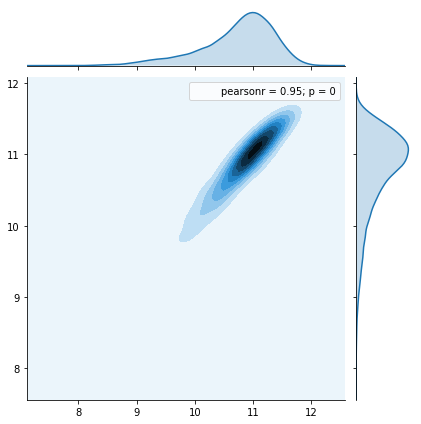

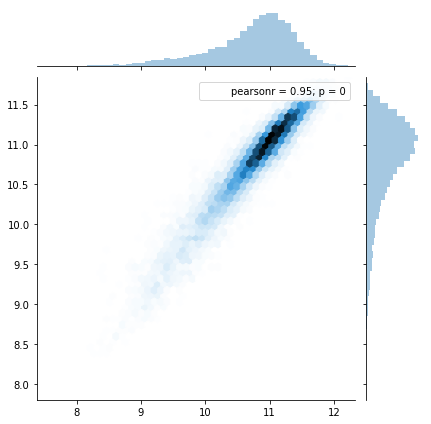

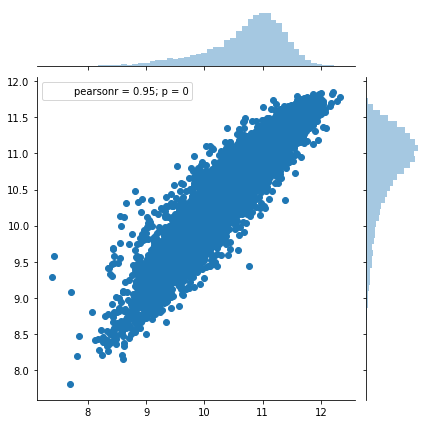

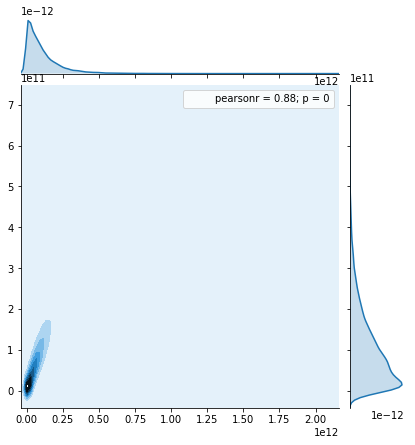

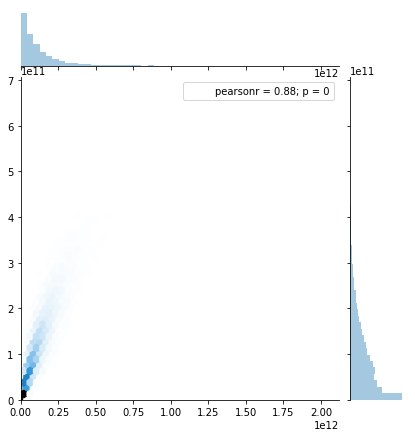

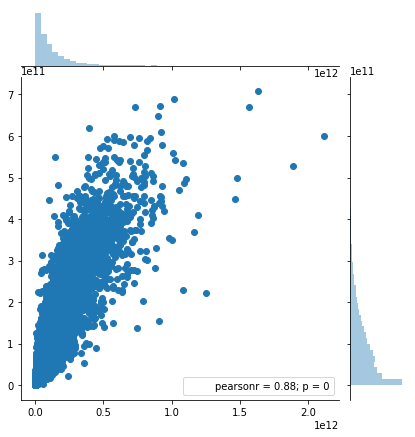

In [67]:
sns.jointplot(x=Y[M:], y=pred, kind='kde')
sns.jointplot(x=Y[M:], y=pred, kind='hex')
sns.jointplot(x=Y[M:], y=pred)


sns.jointplot(x=10**Y[M:], y=10**pred, kind='kde')
sns.jointplot(x=10**Y[M:], y=10**pred, kind='hex')
sns.jointplot(x=10**Y[M:], y=10**pred)
# plt.scatter(x=10**Y[M:], y=10**pred)
